### Projectile

r, v, a, mass, friction.

In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [19]:
class Projectile():
	def __init__(self, r0, v0, t_span, c, g=9.81):
		"""
		Initializes a projectile object with initial position r0, initial velocity v0, time span t_span, air friction coeficient c and acceleration due to gravity g.
		"""
		self.t = t_span
		x0, y0 = r0
		vx0, vy0 = v0
		self.x = x0
		self.y = y0
		self.c = c
	
	def trajectory(self):
		"""
		Returns the trajectory of the projectile (with aire resistance).
		"""
		pass
		

	def peak(self):
		"""
		Returns the time, x and y coordinates of the peak of the projectile trajectory.
		"""
		return self.t[np.argmax(self.y)], self.x[np.argmax(self.y)], np.max(self.y)

In [20]:
p = Projectile((0, 0), (10, 20), np.linspace(0, 5, 40))

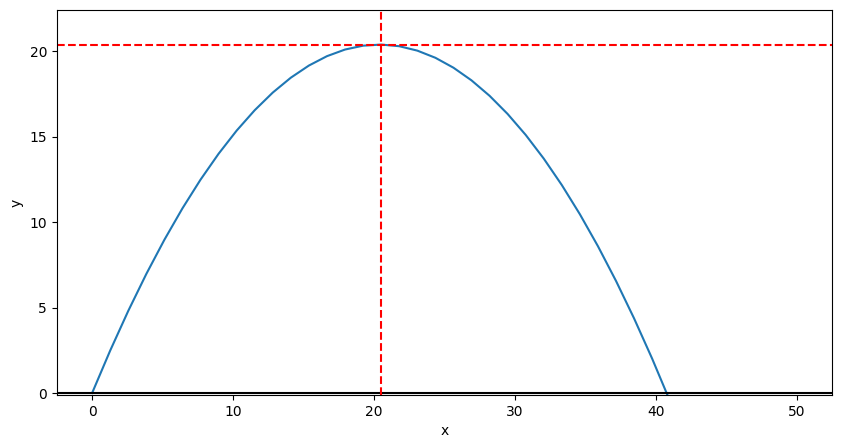

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(p.x, p.y)
plt.axhline(0, color='k')
plt.axhline(p.peak()[2], color='r', linestyle='--')
plt.axvline(p.peak()[1], color='r', linestyle='--')
plt.ylim(-0.1, p.peak()[2]*1.1)
plt.xlabel('x')
plt.ylabel('y')
plt.show()